In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import json
import random

from IPython.display import Audio, display
import sys
import os

import torch

sys.path.append(os.path.abspath('../../'))
sns.color_palette("Blues", as_cmap=True)

# UNKNOWN_PROJECT = 'ml-julka/2_classes_run_optimal_configs_ViT'
# KNOWN_PROJECT = 'ml-julka/11_classes_run_optimal_configs_ViT'
# UNKNOWN_PROJECT = 'ml-julka/2_classes_run_optimal_configs_M5'
# KNOWN_PROJECT = 'ml-julka/11_classes_run_optimal_configs_M5'
UNKNOWN_PROJECT = '2_classes_run_optimal_configs_Conformer'
KNOWN_PROJECT = '11_classes_run_optimal_configs_Conformer'
NAME = 'conformer'
MODE = 'testing'

In [2]:
log_dir_2 = os.path.join("..", "..", "logs", UNKNOWN_PROJECT)
if not os.path.exists(log_dir_2):
    print(f"Folder '{log_dir_2}' does not exist.")
else:
    run_dirs_2 = sorted(glob(os.path.join(log_dir_2, 'run_*')),
                      key=lambda x: int(os.path.basename(x).split('_')[1]))
    print(f"Found {len(run_dirs_2)} runs for unknown.")

Found 5 runs for unknown.


In [3]:
log_dir_11 = os.path.join("..", "..", "logs", KNOWN_PROJECT)
if not os.path.exists(log_dir_11):
    print(f"Folder '{log_dir_11}' does not exist.")
else:
    run_dirs_11 = sorted(glob(os.path.join(log_dir_11, 'run_*')),
                      key=lambda x: int(os.path.basename(x).split('_')[1]))
    print(f"Found {len(run_dirs_11)} runs for known.")

Found 5 runs for known.


In [4]:
def get_results(run_dirs):
    max_accuracies = []
    for run_dir in run_dirs[1:]:
        val_csv = os.path.join(run_dir, 'validation_metrics.csv')
        if os.path.exists(val_csv):
            df = pd.read_csv(val_csv)
            max_acc = df['acc/val'].max()
            run_num = os.path.basename(run_dir).split('_')[1]
            max_accuracies.append((int(run_num), max_acc))

    results = pd.DataFrame(max_accuracies, columns=['Run', 'Max Validation Accuracy'])
    return results

In [5]:
results_11 = get_results(run_dirs_11)
print("\nStatistical Summary of 11 class:")
print(results_11['Max Validation Accuracy'].describe())


Statistical Summary of 11 class:
count    4.000000
mean     0.894687
std      0.002953
min      0.891437
25%      0.892584
50%      0.894878
75%      0.896980
max      0.897554
Name: Max Validation Accuracy, dtype: float64


In [6]:
results_2 = get_results(run_dirs_2)
print("\nStatistical Summary of 2 class:")
print(results_2['Max Validation Accuracy'].describe())


Statistical Summary of 2 class:
count    4.000000
mean     0.929136
std      0.008008
min      0.920287
25%      0.926101
50%      0.928258
75%      0.931293
max      0.939740
Name: Max Validation Accuracy, dtype: float64


In [7]:
best_run_2 = results_2.loc[results_2['Max Validation Accuracy'].idxmax()]

print("Best Performing Run:")
print(best_run_2['Run'])

Best Performing Run:
5.0


In [8]:
best_run_11 = results_11.loc[results_11['Max Validation Accuracy'].idxmax()]

print("Best Performing Run:")
print(best_run_11['Run'])

Best Performing Run:
4.0


In [9]:
UKNOWN_RUN = best_run_2['Run'].astype(int)
KNOWN_RUN = best_run_11['Run'].astype(int)

LOGS_DIR = '../../logs'

CONFIG_UNKNOWN = f'{LOGS_DIR}/{UNKNOWN_PROJECT}/run_{UKNOWN_RUN}/config.json'
MODEL_PATH_UNKNOWN = f"{LOGS_DIR}/{UNKNOWN_PROJECT}/run_{UKNOWN_RUN}/best.pth"
CONFIG_KNOWN = f'{LOGS_DIR}/{KNOWN_PROJECT}/run_{KNOWN_RUN}/config.json'
MODEL_PATH_KNOWN = f"{LOGS_DIR}/{KNOWN_PROJECT}/run_{KNOWN_RUN}/best.pth"

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../'))

with open(CONFIG_KNOWN) as f:
    cfg = json.load(f)

class Config:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            if isinstance(v, dict):
                setattr(self, k, Config(v))
            else:
                setattr(self, k, v)

cfg = Config(cfg)
cfg.data.root = os.path.join('..', '..', 'data')

cfg.data.unknown_commands_included = True
cfg.data.silence_included = True
cfg.data.unknown_binary_classification = False

In [11]:
with open(CONFIG_UNKNOWN) as f:
    cfg_un = json.load(f)

cfg_un = Config(cfg_un)
cfg_un.data.root = os.path.join('..', '..', 'data')

cfg_un.data.unknown_commands_included = True
cfg_un.data.silence_included = True
cfg_un.data.unknown_binary_classification = False

In [12]:
from dataset.dataset import SpeechCommandsDataset

test_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode=MODE
)
print(test_dataset.target_commands)


test_dataset_un = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg_un,
    mode=MODE
)

num_classes:  12
Class balance in testing data:
  down: 253
  go: 251
  left: 267
  no: 252
  off: 262
  on: 246
  right: 259
  stop: 249
  up: 272
  yes: 256
  _silence_: 39
  _unknown_: 4268
  unknown percentage: 62.09%
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_']
num_classes:  12
Class balance in testing data:
  down: 253
  go: 251
  left: 267
  no: 252
  off: 262
  on: 246
  right: 259
  stop: 249
  up: 272
  yes: 256
  _silence_: 39
  _unknown_: 4268
  unknown percentage: 62.09%


In [13]:
import torch
from modeling.model import build_model

model_known = build_model(cfg, 11)

state_dict = torch.load(MODEL_PATH_KNOWN, map_location=torch.device('cpu'))
model_known.load_state_dict(state_dict)

model_unknown = build_model(cfg_un, 2)

state_dict = torch.load(MODEL_PATH_UNKNOWN, map_location=torch.device('cpu'))
model_unknown.load_state_dict(state_dict)

print("Model loaded successfully!")

/home/mytkom/Documents/DeepLearningSpeechRecognition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


In [14]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot_confusion_matrix(model_unknown, model_known, test_dataset, test_dataset_un):
    model_unknown.to(device)
    model_unknown.eval()
    model_known.to(device)
    model_known.eval()

    true_labels = []
    predicted_labels = []

    for idx in range(len(test_dataset)):
        data, true_label = test_dataset[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            output_known = torch.softmax(model_known(data_tensor), dim=1)

        # print(f"True label: {true_label}, Known output: {output_known}")

        data, true_label = test_dataset_un[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            output_unknown = torch.softmax(model_unknown(data_tensor), dim=1)

        # print(f"True label: {true_label}, Unknown output: {output_unknown}")

        if output_known[0][10] < 0.5 and output_unknown[0][1] > 0.5:
            output = torch.cat((output_known * 0., torch.tensor([[output_unknown[0][1]]], device=device)), dim=1)
        else:
            output = torch.cat((output_known, torch.tensor([[0.]], device=device)), dim=1)

        predicted_label = torch.argmax(output, dim=1).item()

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    print(f"Accuracy: {accuracy:.3f}")

    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_dataset.label_mapping.keys()))

    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format=".2f", ax=ax)
    plt.gca().grid(False)
    plt.title("Accuracy: {:.3f}".format(accuracy))
    plt.tight_layout()
    plt.savefig(f'../../charts/{NAME}.png', dpi=600)
    plt.show()

Accuracy: 0.906


<Figure size 1000x1000 with 0 Axes>

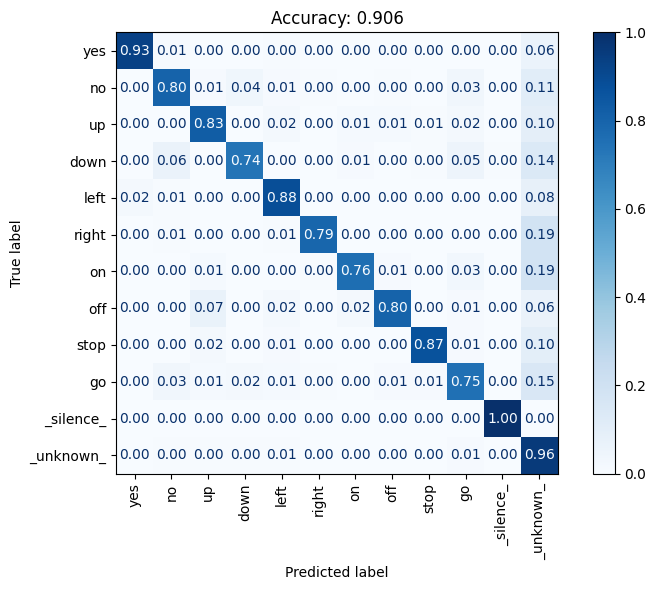

In [15]:
evaluate_and_plot_confusion_matrix(model_unknown, model_known, test_dataset, test_dataset_un)

In [16]:
def evaluate_and_display_wrong_predictions(model, test_dataset, n=5):
    model.to(device)
    model.eval()

    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    wrong_predictions = []

    for idx in indices:
        data, true_label = test_dataset[idx]
        if true_label != 10:
            continue
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(data_tensor)
            probabilities = torch.softmax(output, dim=1)
            predicted_label = torch.argmax(output, dim=1).item()
            prediction_certainty = probabilities[0, predicted_label].item()

        if predicted_label != true_label:
            wrong_predictions.append((idx, true_label, predicted_label, prediction_certainty))

        if len(wrong_predictions) >= n:
            break

    for idx, true_label, predicted_label, prediction_certainty in wrong_predictions:
        print(f"Sample Index: {idx}")
        print(f"{true_label}, {predicted_label}, {prediction_certainty}")

        def get_key_by_value(dictionary, value):
            return next((k for k, v in dictionary.items() if v == value), '')
        true_label_name = get_key_by_value(test_dataset.label_mapping, true_label)
        predicted_label_name = get_key_by_value(test_dataset.label_mapping, predicted_label)
        print(f"True Label: {true_label_name}, Predicted Label: {predicted_label_name}")
        print(f"Prediction Certainty: {prediction_certainty:.2f}")

        waveform, _ = test_dataset.get_waveform(idx)
        display(Audio(waveform, rate=cfg.data.sample_rate))
        print("-" * 50)

In [17]:
evaluate_and_display_wrong_predictions(model, test_dataset)


NameError: name 'model' is not defined